## Introduction 

Heart disease is a leading cause of death worldwide for both men and women, as well as most ethnic groups. Compared to other causes of death, cardiovascular disease has the highest mortality rate. In 2005 alone, it caused the deaths of 17.5 million people globally. A Domestic Health Survey conducted by the Indonesian Ministry of Health in 2001 found that the prevalence of cardiovascular disease in Indonesia was 4.2%, accounting for 26.3% of all deaths in Indonesia (Delmi et al., 2021). Not only does heart disease have an extremely high mortality rate, but it also places significant pressure on global healthcare systems due to its economic burden on society.

The World Health Organization estimated that global economic losses due to ischemic heart diseases, stroke, and congestive heart failure amounted up 863 billion USD in 2010 alone; this figure is projected to increase significantly by 2030 (1,044 billion USD). 

Given these statistics, predicting cardiovascular disease has become a critical issue in clinical data analysis. The healthcare industry generates vast amounts of data that can be transformed into valuable information through data mining techniques to aid decision-making and prediction (Mohammad Shafenoor Amin et al., 2018). 

Our project aims to develop a predictive model based on clinical and demographic features that accurately classifies patients at risk for developing heart disease.  We will use a dataset from the UCI Machine Learning Repository containing lifestyle factors, medical history, demographics among others attributes which includes primarily detecting presence or absence of heart disease in patients. However, we will only analyze a subset of 14 features used in previous studies.  Our goal is to provide medical professionals with an early intervention tool for preventing heart disease by predicting and identifying potential cases. 

##### For context, a brief overview of our 13 selected variables:
- Oldpeak - ST depression measurement from an ECG
- Thalach - maximum heart rate achieved by participant
- Age - age of participant
- Sex - sex of participant
- CP - type of chest pain experienced
- Trestbps - resting blood pressure
- Chol - serum cholesterol found in blood
- FBS - fasting blood sugar of participant
- Restecg - resting ECG results
- Exang - exercise induced angina (chest pain)
- Slope - slope of the peak exercise ST segment from ECG
- Ca - number of major vessels
- Thal - presence of thalassemia


#### Figure and Table Legend
- Table 1: Table displaying difference in model accuracy with each predictor
- Figure 2: Graph plotting model accuracy in respects to predictor selection
- Table 3: Summary of all predictors and their observations with heart disease
- Table 4: Summary of all predictors and their observations without heart disease
- Figure 5: Histogram comparing oldpeak in heart disease cases
- Figure 6: Boxplot comparing spread of resting blood pressue
- Figure 7: Bar graphs comparing number of major vessels
- Figure 8: Bar graphs comparing resting ECG measurement
- Figure 9: Bar graphs representing different types of reported chest pain
- Figure 10: Bar graphs comparing the types of slopes in ST segments
- Figure 11: Bar graphs comparing the proportion of thalassemia status
- Figure 12: Line graph plotting accuracy estimate for selection of K


## Method and Results

#### Methodology

In order to build the most efficient and accurate classifier, we will take the following steps to build our classifier

1. Reading the data file and converting it into tidy and human readable format.
2. Use foward selection method to see how accuracy changes with the number of predictors variable with cross validation
3. Select the variables contributing positively to accuracy and construct the best formula for the model
4. Use the best formula to tune and find the best number of neighbors for classifier
5. Predict the test set with classifier and produce the result. 


In [15]:
library(tidyverse)
library(forcats)
library(tidymodels)
library(rvest)
library(gridExtra)
library(stringr)
library(lattice)

In [4]:
heart_disease_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data")

name <- c("age","sex","cp","trestbps","chol","fbs","restecg","thalach","exang",
          "oldpeak","slope","ca","thal","status")

colnames(heart_disease_data) <- name

New names:
• `1.0` -> `1.0...2`
• `1.0` -> `1.0...3`
• `1.0` -> `1.0...6`
• `0.0` -> `0.0...9`
• `0.0` -> `0.0...12`
Rows: 302 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): 0.0...12, 6.0
dbl (12): 63.0, 1.0...2, 1.0...3, 145.0, 233.0, 1.0...6, 2.0, 150.0, 0.0...9...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


#### Reading the data file and converting it into tidy and human readable format

In [5]:
heart_disease_data_as_factors <- heart_disease_data|>
  mutate(
    sex=ifelse(sex== 1, "Male","Female"),                                 
    cp=ifelse(cp == 1, "typical",                                         
              ifelse(cp == 2, "atypical", 
                     ifelse(cp== 3, "non-anginal", 
                            "asymptomatic"))),
    fbs=ifelse(fbs == 0, "Normal","High"),                                
    restecg=ifelse(restecg==0,"Normal",                                    
                   ifelse(restecg==1,"Abnormal","Definite")),
    exang=ifelse(exang==1,"yes","no"),                               
    slope=ifelse(slope == 1, "upsloping",       
                 ifelse(slope==2,"flat","downsloping")),
    ca=as_factor(ca),
    thal=ifelse(thal=="3.0","normal",
                ifelse(thal=="6.0","fixed defect","reversable defect")),
    status=ifelse(status==0,"absent","present"))|>                         
  mutate_if(is.character, as.factor)|>
  filter(ca!="?")

head(heart_disease_data_as_factors,n=10)

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,status
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>
67,Male,asymptomatic,160,286,Normal,Definite,108,yes,1.5,flat,3.0,normal,present
67,Male,asymptomatic,120,229,Normal,Definite,129,yes,2.6,flat,2.0,reversable defect,present
37,Male,non-anginal,130,250,Normal,Normal,187,no,3.5,downsloping,0.0,normal,absent
41,Female,atypical,130,204,Normal,Definite,172,no,1.4,upsloping,0.0,normal,absent
56,Male,atypical,120,236,Normal,Normal,178,no,0.8,upsloping,0.0,normal,absent
62,Female,asymptomatic,140,268,Normal,Definite,160,no,3.6,downsloping,2.0,normal,present
57,Female,asymptomatic,120,354,Normal,Normal,163,yes,0.6,upsloping,0.0,normal,absent
63,Male,asymptomatic,130,254,Normal,Definite,147,no,1.4,flat,1.0,reversable defect,present
53,Male,asymptomatic,140,203,High,Definite,155,yes,3.1,downsloping,0.0,reversable defect,present


#### Predictor variable selection using foward selection method

In [6]:
## split the training set and test set 
## note that we will only use training set for selecting our model

## Since during our for-loop, it is hard to execute scaling and centering in recipe 
## (since not all variables are quantitatve), we will scale the columns that is 
## numberic and also cross-validating with scaled dataset

## The following methods is a reference to chapter 6.8 in the textbook "Predictor variable selection"

heart_scaled <- heart_disease_data_as_factors|>
  mutate(age=scale(age),
         trestbps=scale(trestbps),
         chol=scale(chol),
         thalach=scale(thalach),
         oldpeak=scale(oldpeak))

set.seed(1984)
heart_split_scaled <- initial_split(heart_scaled, prop = 0.75, strata = status)
heart_train_scaled <- training(heart_split_scaled)
heart_test_scaled <- testing(heart_split_scaled)

heart_vfold_scaled <- vfold_cv(heart_train_scaled, v = 5, strata = status)

head(heart_scaled)

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,status
"<dbl[,1]>",<fct>,<fct>,"<dbl[,1]>","<dbl[,1]>",<fct>,<fct>,"<dbl[,1]>",<fct>,"<dbl[,1]>",<fct>,<fct>,<fct>,<fct>
1.3853948,Male,asymptomatic,1.60147943,0.74722313,Normal,Definite,-1.8050022,yes,0.3887806,flat,3.0,normal,present
1.3853948,Male,asymptomatic,-0.65604597,-0.34902252,Normal,Definite,-0.8917014,yes,1.3341982,flat,2.0,reversable defect,present
-1.9395528,Male,non-anginal,-0.09166462,0.05485746,Normal,Normal,1.6307483,no,2.1077216,downsloping,0.0,normal,absent
-1.4962264,Female,atypical,-0.09166462,-0.82983201,Normal,Definite,0.9783906,no,0.3028336,upsloping,0.0,normal,absent
0.1662474,Male,atypical,-0.65604597,-0.21439586,Normal,Normal,1.2393336,no,-0.2128487,upsloping,0.0,normal,absent
0.8312369,Female,asymptomatic,0.47271673,0.40104029,Normal,Definite,0.4565044,no,2.1936687,downsloping,2.0,normal,present


In [5]:
names <- colnames(heart_train_scaled |> select(-status))


accuracies1 <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

# the names of the predictor variables we are adding on 
names

[1] "age"      "sex"      "cp"       "trestbps" "chol"     "fbs"     
 [7] "restecg"  "thalach"  "exang"    "oldpeak"  "slope"    "ca"      
[13] "thal"

In [6]:
##here we pick k=5 

knn_spec_tune <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

n_total <- length(names)

selected <- c()

set.seed(1984)
for (i in 1:n_total) {
  accs <- list()
  models <- list()
  for (j in 1:length(names)) {
    preds_new <- c(selected, names[[j]])
    model_string <- paste("status", "~", paste(preds_new, collapse="+"))
    heart_recipe_scaled <- recipe(as.formula(model_string), 
                            data = heart_train_scaled)
    acc <- workflow() |>
      add_recipe(heart_recipe_scaled) |>
      add_model(knn_spec_tune) |>
      tune_grid(resamples = heart_vfold_scaled, grid = 5) |>
      collect_metrics() |>
      filter(.metric == "accuracy") |>
      summarize(mx = max(mean))
    acc <- acc$mx |> unlist()
    accs[[j]] <- acc
    models[[j]] <- model_string
  }

  jstar <- which.max(unlist(accs))
  accuracies1 <- accuracies1 |> 
    add_row(size = i, 
            model_string = models[[jstar]], 
            accuracy = accs[[jstar]])
  selected <- c(selected, names[[jstar]])
  names <- names[-jstar]
}

In [9]:
##The following is the result of formulas and the accuracy associate with it 

accuracies_diff <- accuracies1|>
  mutate(diff=(accuracy-lag(accuracy))*100)

accuracies_diff

size,model_string,accuracy,diff
<int>,<chr>,<dbl>,<dbl>
1,status ~ oldpeak,0.7220202,NA
2,status ~ oldpeak+thal,0.7851515,6.3131313
3,status ~ oldpeak+thal+ca,0.8073737,2.2222222
4,status ~ oldpeak+thal+ca+cp,0.8431313,3.5757576
5,status ~ oldpeak+thal+ca+cp+slope,0.8478788,0.4747475
6,status ~ oldpeak+thal+ca+cp+slope+restecg,0.8565657,0.8686869
7,status ~ oldpeak+thal+ca+cp+slope+restecg+trestbps,0.8700000,1.3434343
8,status ~ oldpeak+thal+ca+cp+slope+restecg+trestbps+chol,0.8609091,-0.9090909
9,status ~ oldpeak+thal+ca+cp+slope+restecg+trestbps+chol+age,0.8566667,-0.4242424


##### Table 1
Table showing difference in accuracy of our model with each additional predictor value

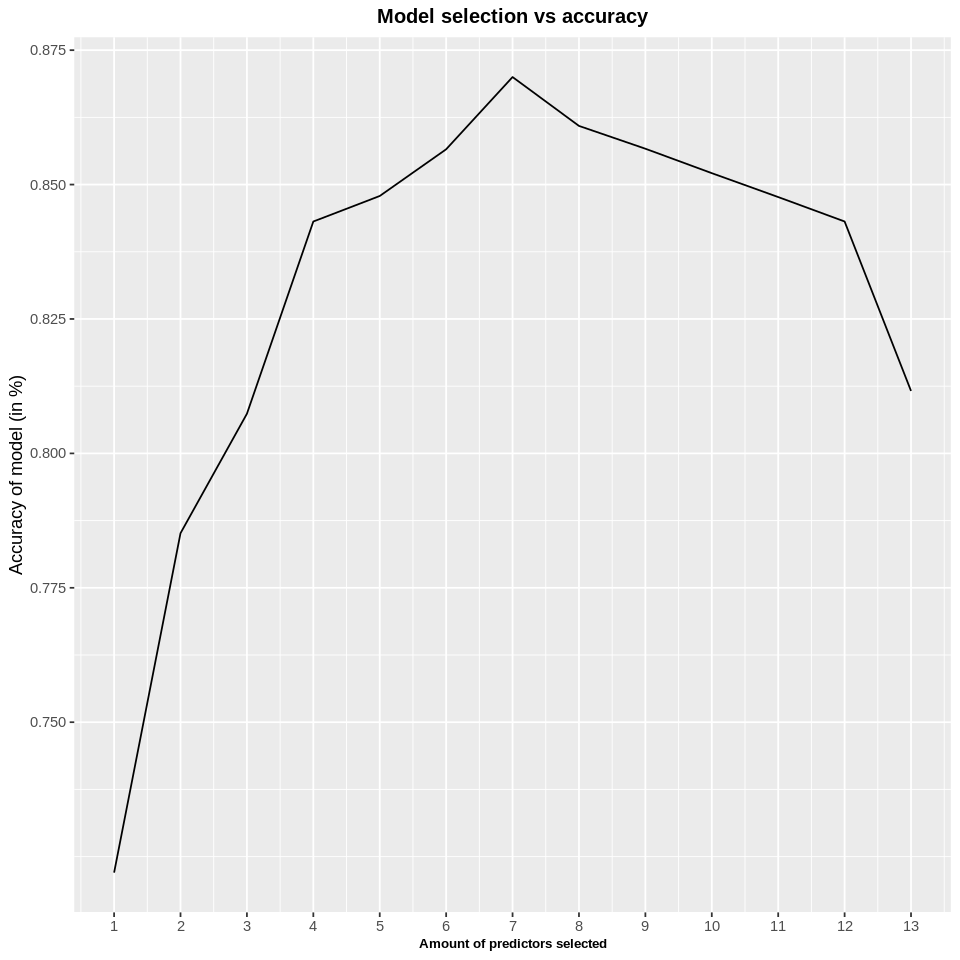

In [85]:
options(repr.plot.width = 8, repr.plot.height = 8)
model_selection_plot <- accuracies1|>
  ggplot(aes(x=size,y=accuracy))+
  geom_line()+
  scale_x_continuous(breaks=c(1,2,3,4,5,6,7,8,9,10,11,12,13,14))+
  scale_y_continuous(breaks=c(0.75,0.775,0.8,0.825,0.85,0.875))+
  labs(x="Amount of predictors selected",y="Accuracy of model (in %)",
       title="Model selection vs accuracy")+
  theme(plot.title=element_text(size=12,face="bold",hjust=0.5))+
  theme(axis.title.x=element_text(size=8,face="bold",hjust=0.5))

model_selection_plot

In [23]:
model<-as.formula("status ~ oldpeak+thal+ca+cp+slope+restecg+trestbps")

##### Figure 2
Graph showing the accuracy of our model as we add more predictors. The highest accuracy is around 7 predictors; drop off as we add more predictors after.

#### Data analysis on relative predictors

In [10]:
set.seed(1198)
heart_split <- initial_split(heart_disease_data_as_factors, prop = 0.75, strata = status)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

In [11]:
## summary of predictors with respect to status of heart diseases 
sum_present<-heart_train|>
    filter(status=="present")|>
    select(oldpeak,thal,ca,cp,slope,restecg,trestbps)|>
    summary()

sum_absent<-heart_train|>
    filter(status=="absent")|>
    select(oldpeak,thal,ca,cp,slope,restecg,trestbps)|>
    summary()

In [12]:
sum_present

    oldpeak                     thal      ca                cp    
 Min.   :0.000   fixed defect     : 8   3.0:15   asymptomatic:77  
 1st Qu.:0.600   normal           :30   2.0:23   atypical    : 7  
 Median :1.400   reversable defect:65   0.0:33   non-anginal :13  
 Mean   :1.635                          1.0:32   typical     : 6  
 3rd Qu.:2.550                          ?  : 0                    
 Max.   :6.200                                                    
         slope        restecg      trestbps    
 downsloping:10   Abnormal: 3   Min.   :100.0  
 flat       :67   Definite:55   1st Qu.:120.0  
 upsloping  :26   Normal  :45   Median :130.0  
                                Mean   :132.9  
                                3rd Qu.:140.0  
                                Max.   :180.0  

##### Table 3
Summary/count of all predictors' in those where heart disease is present.

In [1]:
sum_absent

ERROR: Error in eval(expr, envir, enclos): object 'sum_absent' not found


##### Table 4
Summary/count of all predictors' in those where heart disease is absent.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



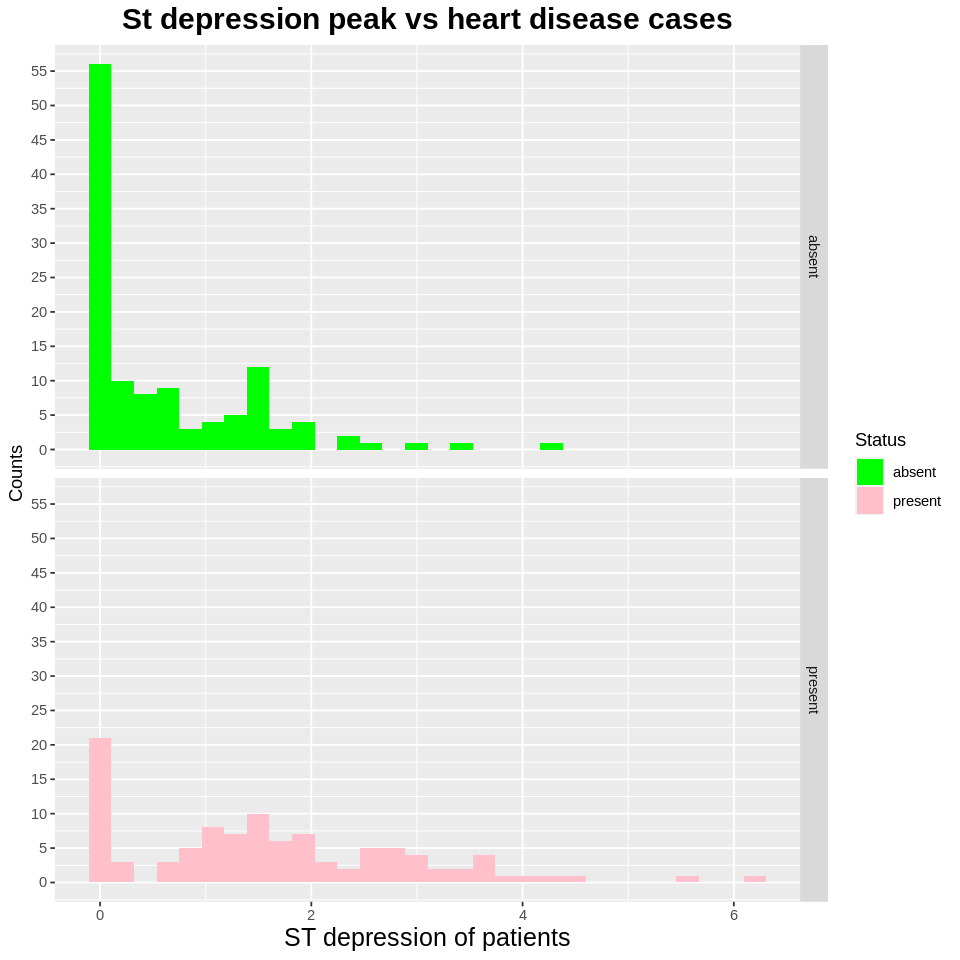

In [14]:
## graph with respect to oldpeak
options(repr.plot.width = 8, repr.plot.height = 8)
oldpeak_vs_status <-heart_train|>
    ggplot(aes(x=oldpeak,fill=status))+
    geom_histogram()+
    facet_grid(rows=vars(status))+
    labs(x="ST depression level of patients",
       y="Counts",
       fill="Status",
       title="St depression peak vs heart disease cases")+
    theme(plot.title=element_text(size=18,face="bold"))+
  theme(plot.title=element_text(hjust=0.5))+
  theme(axis.title.x=element_text(size=15),axis.title.y=element_text(size=11))+
  scale_fill_manual(values=c("green", 'pink'))+
  scale_y_continuous(breaks = seq(0, 100, by = 5))
oldpeak_vs_status

##### Figure 5
Histograms comparing the oldpeak (ST Depression). There is higher oldpeaks for those who have heart disease present. There is lower oldpeak for those who have heart disease absent.

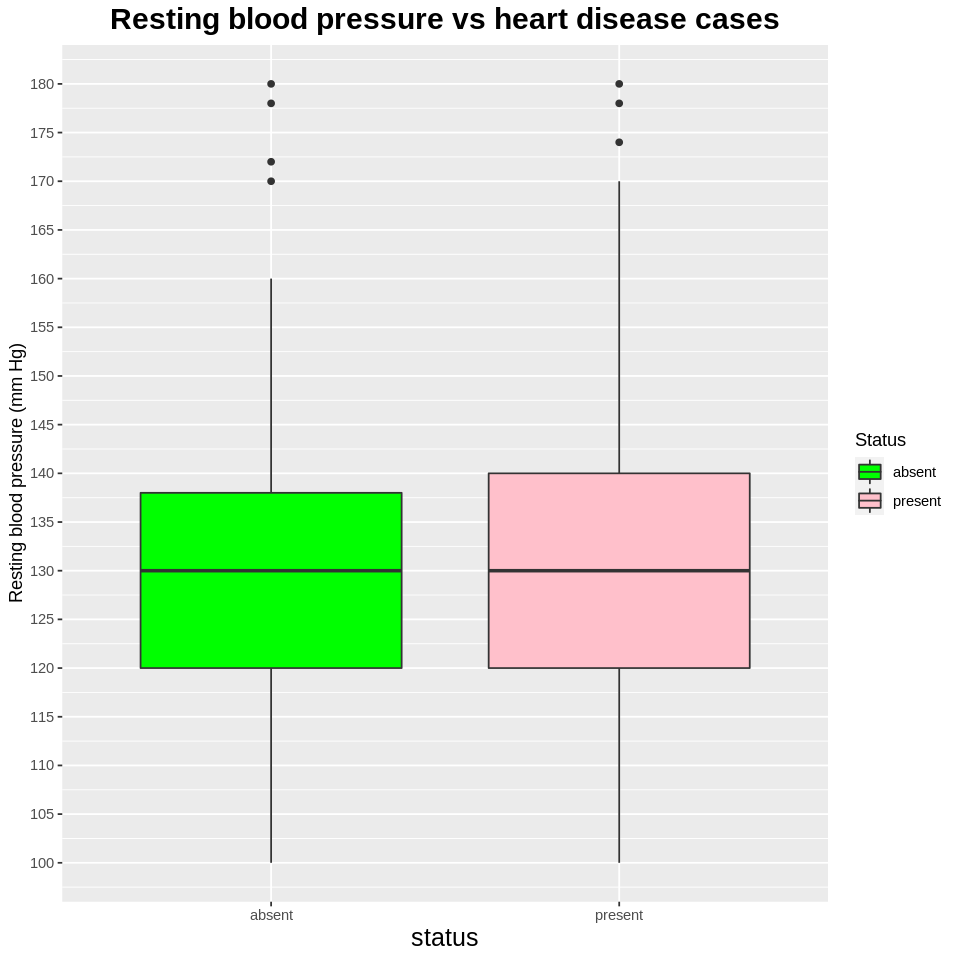

In [117]:
## graph with respect to resting blood pressure

options(repr.plot.width = 8, repr.plot.height = 8)
oldpeak_vs_status <-heart_train|>
    ggplot(aes(x=status,y=trestbps,fill=status))+
    geom_boxplot()+
    labs(y="Resting blood pressure (mm Hg)",
       fill="Status",
       title="Resting blood pressure vs heart disease cases")+
    theme(plot.title=element_text(size=18,face="bold"))+
  theme(plot.title=element_text(hjust=0.5))+
  theme(axis.title.x=element_text(size=15),axis.title.y=element_text(size=11))+
  scale_fill_manual(values=c("green", 'pink'))+
  scale_y_continuous(breaks = seq(0, 200, by = 5))
oldpeak_vs_status

##### Figure 6
Figure comparing the resting blood pressure in those who have heart disease and those who don't. Those with heart disease have a broader range of resting blood pressure, than those without.

`summarise()` has grouped output by 'ca'. You can override using the `.groups`
argument.


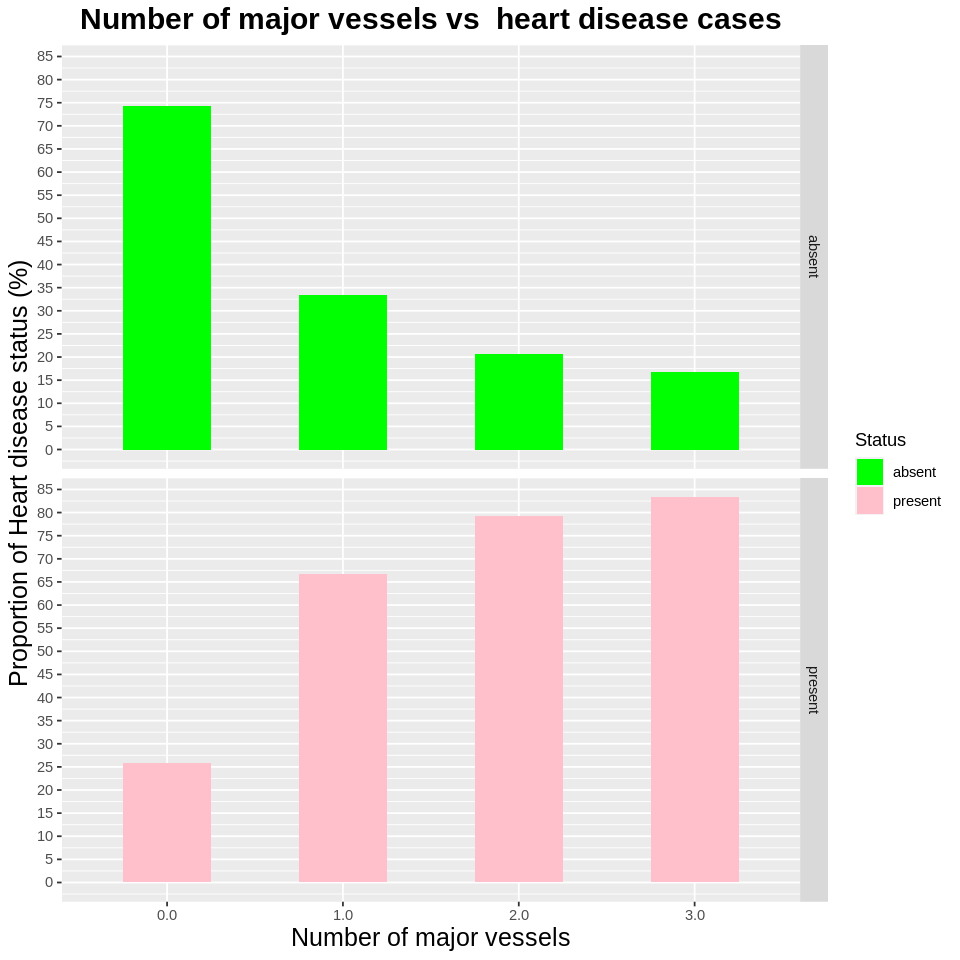

In [118]:
## graph with respect to number of major vessels

options(repr.plot.width = 8, repr.plot.height = 8)

major_vessels <- heart_train|>
    group_by(ca,status)|>
    summarize(count=n())|>
    mutate(percentage=count/sum(count))

ca_vs_status <- major_vessels|>
  ggplot(aes(x = factor(ca,c("0.0","1.0","2.0","3.0")), y=100*percentage,fill=status)) + 
  geom_bar(stat = "identity",width=0.5) +
  labs(x="Number of major vessels",
       y="Proportion of Heart disease status (%)",
       fill="Status",
       title="Number of major vessels vs  heart disease cases")+
  facet_grid(rows=vars(status))+
  theme(plot.title=element_text(size=18,face="bold"))+
  theme(plot.title=element_text(hjust=0.5))+
  theme(axis.title.x=element_text(size=15),axis.title.y=element_text(size=15))+
  scale_fill_manual(values=c('green', 'pink'))+
  scale_y_continuous(breaks = seq(0, 100, by = 5))

ca_vs_status

##### Figure 7
Graphs comparing the number of major vessels in those with and without heart disease. Those with heart disease have more major vessels.

`summarise()` has grouped output by 'restecg'. You can override using the
`.groups` argument.


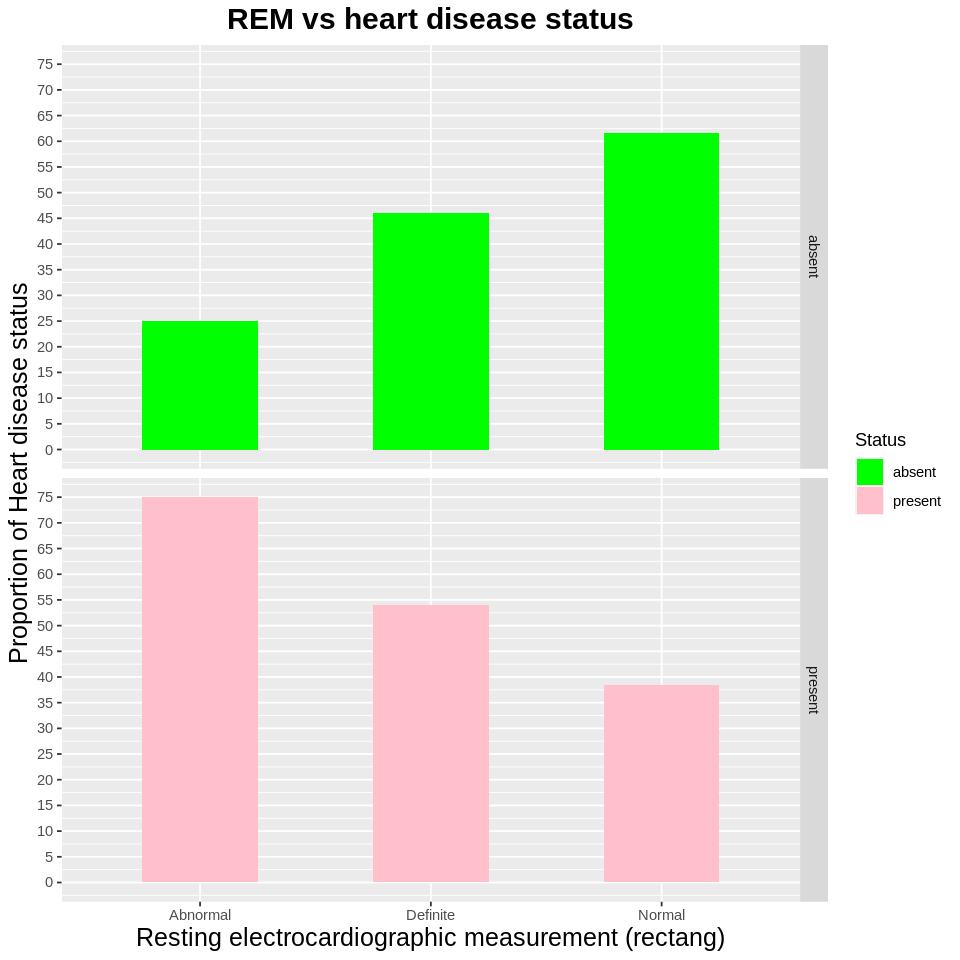

In [129]:
## graph with respect to Resting electrocardiographic measurement (rectang)

options(repr.plot.width = 8, repr.plot.height = 8)

restecg_data <- heart_train|>
    group_by(restecg,status)|>
    summarize(count=n())|>
    mutate(percentage=count/sum(count))

restecg_vs_status <- restecg_data|>
    ggplot(aes(x=restecg,y=100*percentage,fill=status))+
    geom_bar(stat = "identity",width=0.5)+
    facet_grid(rows=vars(status))+
    scale_fill_manual(values=c('green', 'pink'))+
    scale_y_continuous(breaks = seq(0, 100, by = 5))+
    labs(x="Type of resting electrocardiographic measurement (rectang)",
         y="Proportion of Heart disease status",
         fill="Status",
         title="REM vs heart disease status")+
  theme(plot.title=element_text(size=18,face="bold"))+
  theme(plot.title=element_text(hjust=0.5))+
  theme(axis.title.x=element_text(size=15),axis.title.y=element_text(size=15))

restecg_vs_status

##### Figure 8
Graphs comparing the resting ECG measurement. Those with heart disease have more irregular resting ECG measurements (measurements that are not under "normal")

`summarise()` has grouped output by 'cp'. You can override using the `.groups`
argument.


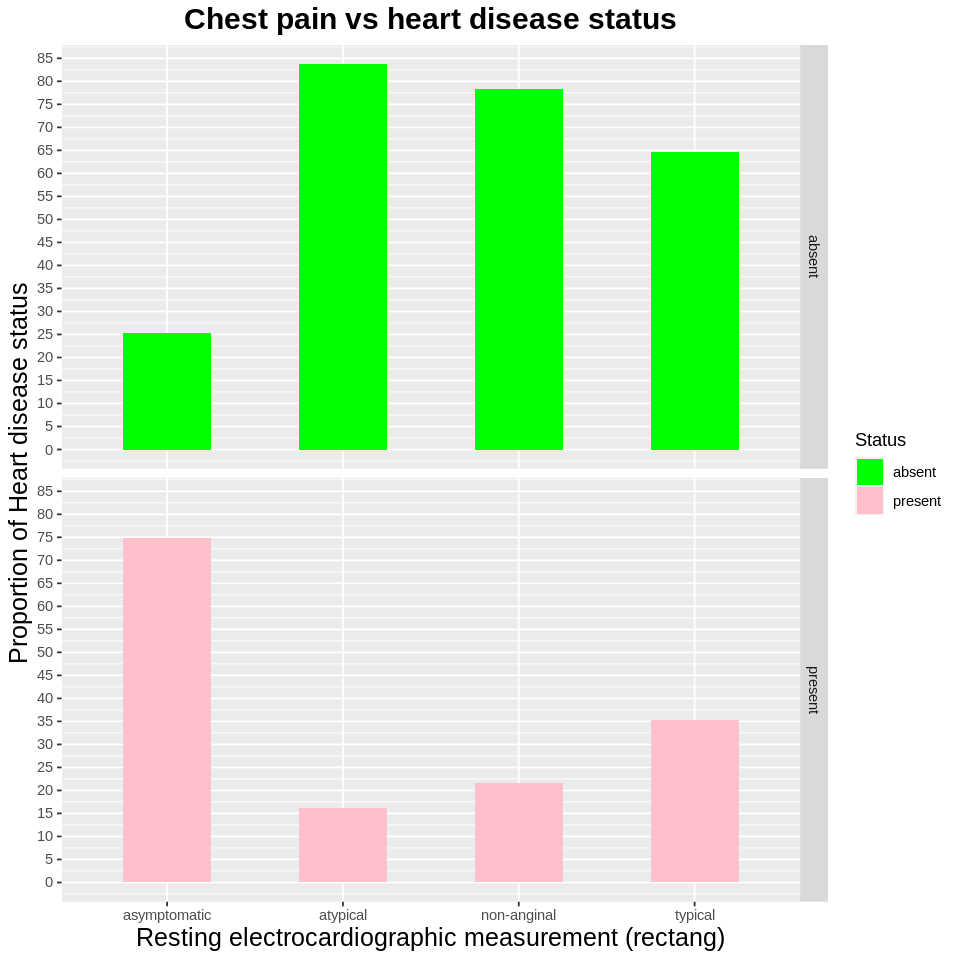

In [131]:
## graph with respect to chest pain

options(repr.plot.width = 8, repr.plot.height = 8)

cp_data <- heart_train|>
    group_by(cp,status)|>
    summarize(count=n())|>
    mutate(percentage=count/sum(count))

restecg_vs_status <- cp_data|>
    ggplot(aes(x=cp,y=100*percentage,fill=status))+
    geom_bar(stat = "identity",width=0.5)+
    facet_grid(rows=vars(status))+
    scale_fill_manual(values=c('green', 'pink'))+
    scale_y_continuous(breaks = seq(0, 100, by = 5))+
    labs(x="Resting electrocardiographic measurement (rectang)",
         y="Proportion of Heart disease status",
         fill="Status",
         title="Chest pain vs heart disease status")+
  theme(plot.title=element_text(size=18,face="bold"))+
  theme(plot.title=element_text(hjust=0.5))+
  theme(axis.title.x=element_text(size=15),axis.title.y=element_text(size=15))

restecg_vs_status

##### Figure 9
Bar graphs representing different types of chest pain separated by presence of heart disease. 

`summarise()` has grouped output by 'slope'. You can override using the
`.groups` argument.


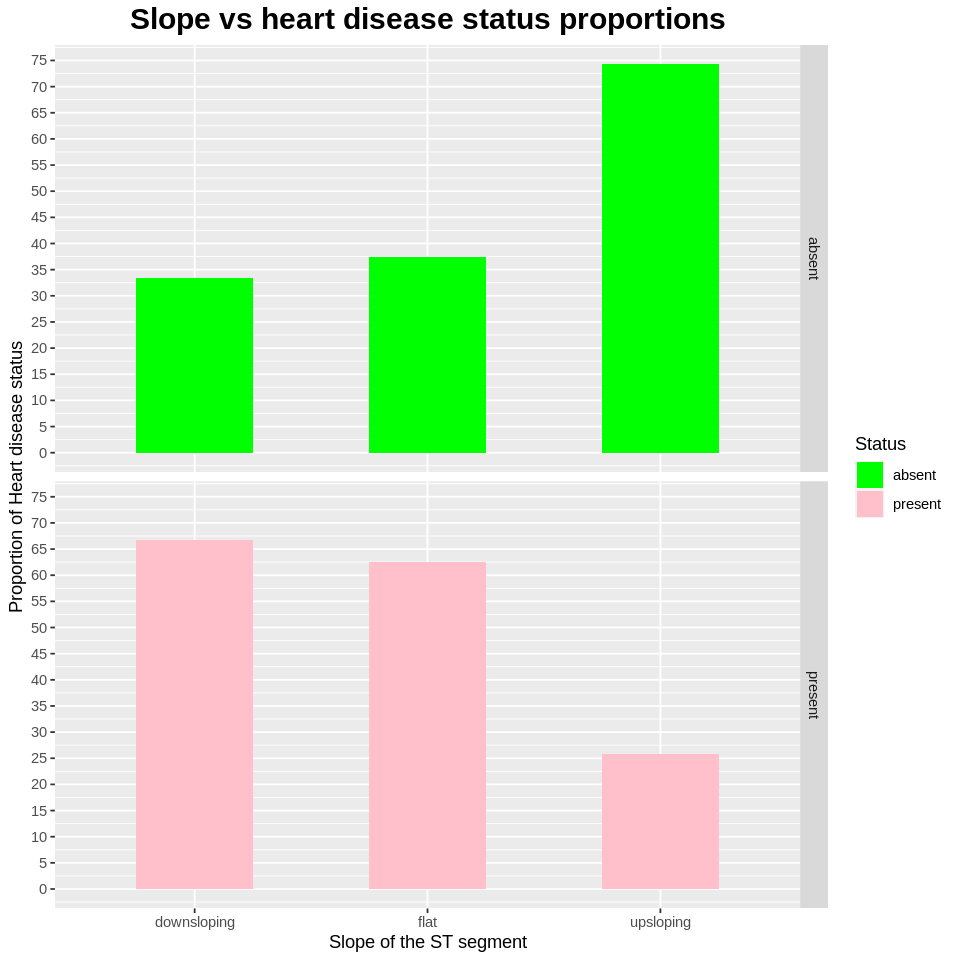

In [133]:
slope_count <- heart_train|>
    group_by(slope,status)|>
    summarize(count=n())|>
    mutate(percentage=count/sum(count))

slope_vs_status <- slope_count|>
  ggplot(aes(x = slope, y=100*percentage,fill=status)) + 
  geom_bar(stat = "identity",width=0.5) +
  labs(x="Slope of the ST segment",
       y="Proportion of Heart disease status",
       fill="Status",
       title="Slope vs heart disease status proportions")+
  facet_grid(rows=vars(status))+
  theme(plot.title=element_text(size=18,face="bold"))+
  theme(plot.title=element_text(hjust=0.5))+
  theme(axis.title.x=element_text(size=11),axis.title.y=element_text(size=11))+
  scale_fill_manual(values=c('green', 'pink'))+
  scale_y_continuous(breaks = seq(0, 100, by = 5))

slope_vs_status

##### Figure 10
Bar graphs comparing the types of slopes of ST segments, separated by presence of heart disease. Those with heart disease have opposite proportions of different types of slopes.

`summarise()` has grouped output by 'thal'. You can override using the
`.groups` argument.


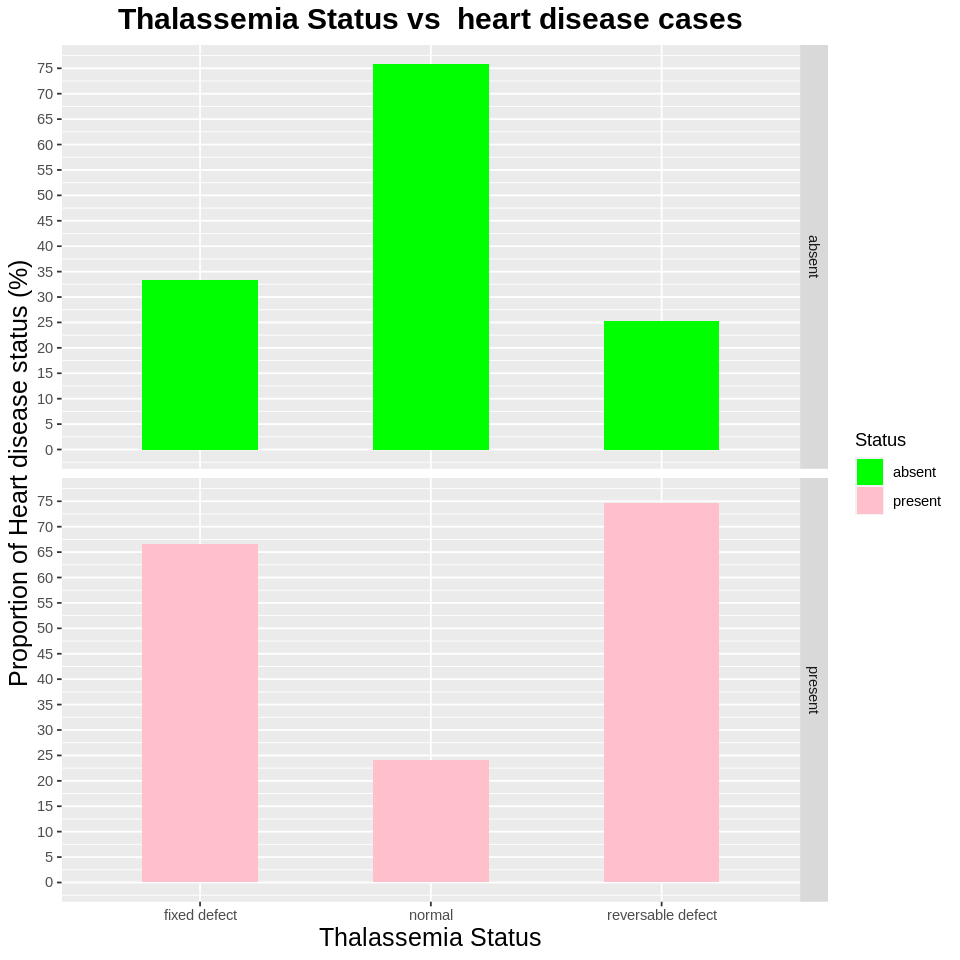

In [78]:
## graph with respect to thal

thal_data <- heart_train|>
    group_by(thal,status)|>
    summarize(count=n())|>
    mutate(percentage=count/sum(count))

thal_vs_status <- thal_data|>
  ggplot(aes(x = thal, y=100*percentage,fill=status)) + 
  geom_bar(stat = "identity",width=0.5) +
  labs(x="Thalassemia Status",
       y="Proportion of Heart disease status (%)",
       fill="Status",
       title="Thalassemia Status vs  heart disease cases")+
  facet_grid(rows=vars(status))+
  theme(plot.title=element_text(size=18,face="bold"))+
  theme(plot.title=element_text(hjust=0.5))+
  theme(axis.title.x=element_text(size=15),axis.title.y=element_text(size=15))+
  scale_fill_manual(values=c('green', 'pink'))+
  scale_y_continuous(breaks = seq(0, 100, by = 5))

thal_vs_status

##### Figure 11
Bar graph comparing the proportion of thalassemia status, separated by presence of heart disease.

#### Classifier tunning and results

In [24]:
set.seed(1198)
heart_split <- initial_split(heart_disease_data_as_factors, prop = 0.75, strata = status)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

In [25]:
knn_spec_tune <- nearest_neighbor(weight_func = "rectangular",neighbors = tune())|>
  set_engine("kknn")|>
  set_mode("classification")

heart_recipe <- recipe(model,data=heart_train)|>
  step_center(oldpeak,trestbps)|>
  step_scale(oldpeak,trestbps)

In [26]:
set.seed(1999)
heart_vfold <- vfold_cv(heart_train, v = 5, strata = status)

gridvals = tibble(neighbors = seq(from=1,to=50, by=2))

knn_tune_result <- workflow()|>
  add_recipe(heart_recipe)|>
  add_model(knn_spec_tune)|>
  tune_grid(resamples = heart_vfold, grid = gridvals)|>
  collect_metrics()|>
  filter(.metric=="accuracy")|>
  arrange(desc(mean))

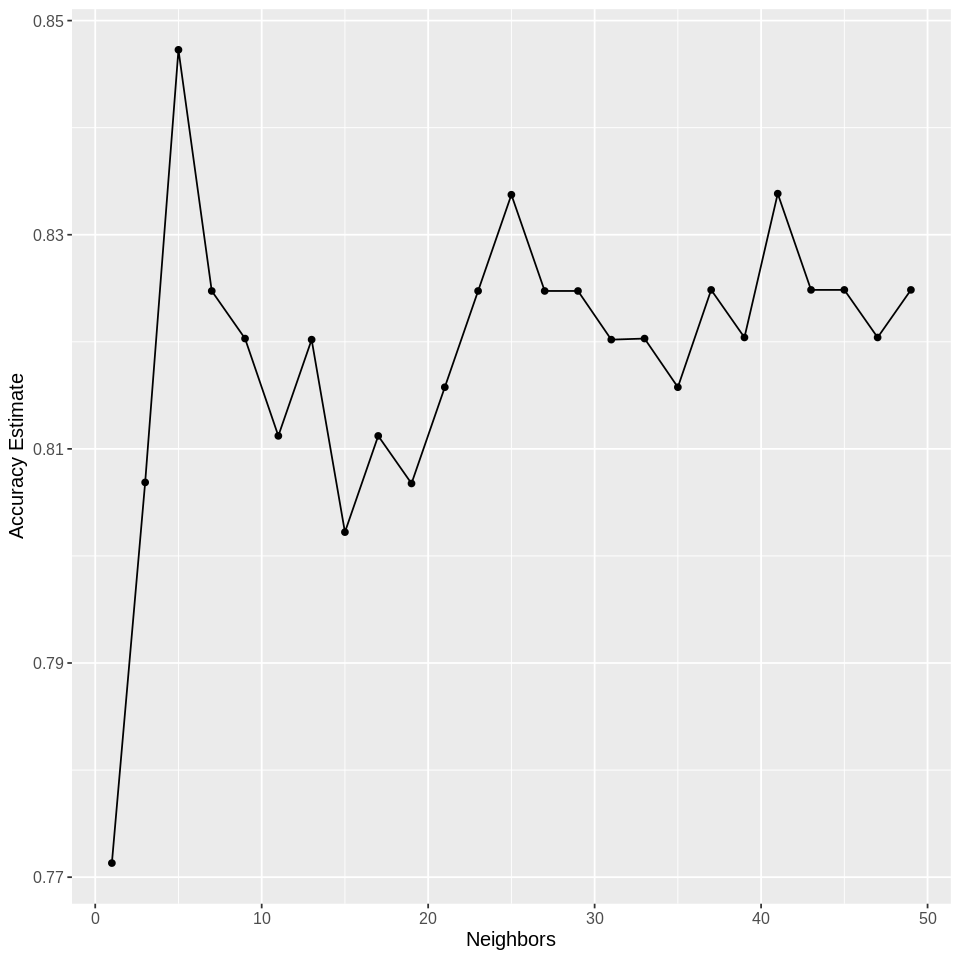

In [27]:
accuracy_vs_k <- ggplot(knn_tune_result, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 12))

accuracy_vs_k

##### Figure 12
Line graph plotting accuracy estimate against K-neighbours.

In [28]:
best_k <- knn_tune_result|>
  slice(1)|>
  pull(neighbors)

knn_spec <- nearest_neighbor(weight_func = "rectangular",neighbors = best_k)|>
  set_engine("kknn")|>
  set_mode("classification")

heart_fit <- workflow()|>
  add_recipe(heart_recipe)|>
  add_model(knn_spec)|>
  fit(data=heart_train)

result <- heart_fit|>
  predict(heart_test)|>
  bind_cols(heart_test)

result_metrics <- result|>
  metrics(truth=status,estimate = .pred_class)|>
  filter(.metric=="accuracy")

result_confusion <- result|>
  conf_mat(truth=status,estimate = .pred_class)

In [69]:
result_confusion

          Truth
Prediction absent present
   absent      37       6
   present      3      29

`summarise()` has grouped output by 'status'. You can override using the
`.groups` argument.


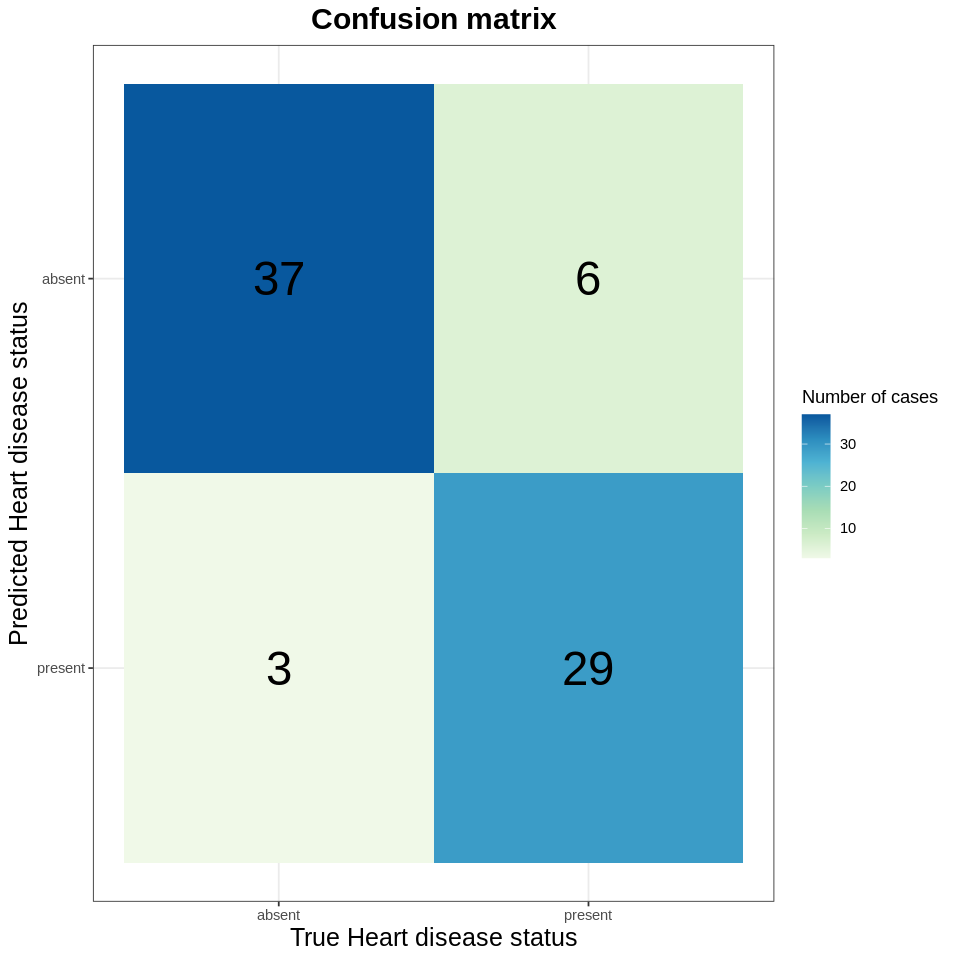

In [77]:
mat<-result|>
    select(status,.pred_class)|>
    group_by(status,.pred_class)|>
    summarize(n = n())

ggplot(mat, aes(x = factor(status,c("absent","present")), y =factor(.pred_class,c("present","absent")), fill = n)) +
            geom_tile() + 
            theme_bw() + 
            scale_fill_distiller(palette="GnBu", direction=1) +
            labs(title = "Confusion matrix", x="True Heart disease status", y= "Predicted Heart disease status",
                fill="Number of cases")+
            theme(plot.title=element_text(size=18,face="bold",hjust=0.5))+
            theme(axis.title.x=element_text(size=15),axis.title.y=element_text(size=15))+
            geom_text(aes(label=n), color="black",size=10)
            
            

In [149]:
result_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.88


## Discussion

#### Figure Legend
- Figure 13: ECG with notations (Burns & Buttner, 2022)
- Figure 14: ECG with notations (Madhero88, 2009)
- Figure 15: Positive ST segment patterns (Chaudhury et al., 2019)
- Figure 16: Types of ST slope (Sibbald, Dąbrowski, & Leśniak, 2002)
- Figure 17: ECG reading of healthy individuals (Szu et al., 2012)


Firstly, we will discuss the 7 predictors that we chose to use in our final model.

1. oldpeak (J point measurement in millimeters)
This refers to ones’ ST segment depression in the electrocardiogram (ECG) relative to the J point during exercise relative to rest (figure 1). The ECG pattern tells the health conditions in ones’ heart, whereas the ST segment corresponds to the period when the myocardium remains contracted for blood removal from the ventricles. When healthy individuals exercise, J point depresses, and ST segment slopes sharply upwards (Hills and TImmis, 2022). When healthy individuals rest, J point is at the isoelectric baseline (figure 2), and ST segment slopes upwards (Polizos and Ellestad, 2006). Demonstration of normal and pathogenic ECGs are shown in figure 3. The larger the “oldpeak” value, the worse the ST depression reading, the higher risk the individual is in heart diseases (Adeli and Neshat, 2010).
    - Examples: Figures 13, 14, 15
   
<img align= "left" src="images/fig13.png" width="400px" > <img align="middle" src= "images/fig14.png"> <img align="right" src="images/fig.15" width="400px">

2. thal (categorized by thallium stress test results)
This refers to the sample’s thallium stress test result (Anon, 2015). It tests for the amount of blood that reaches different parts of the heart. Thallium is a radioactive tracer. Prior to the test, a small amount of thallium is administered into the recipient to help track the movement of the blood in different parts of the heart (Nelson, 2023). In this data set, 3 (i.e. normal) indicates normal blood flow in the heart; 6 (i.e. fixed detect) indicates the obscured blood supply to some parts of the heart; and 7 (i.e. reversible defect) indicates poor blood perfusion in heart vessels (Lee, 1994). Hence, 6 and 7 reflect poor conditions in the heart.

3. ca (quantification of cardiac artery blockage)
This refers to the number of artery blockages found in the heart. By using fluorescent dyes during cardiac catheterization, blood flow in coronary arteries are observed. Fluorescent blood vessels indicate arterial blockages. Consequently, the more vessels are colored by fluoroscopy, the more blocked major cardiac vessels there are (Anon, 2019). Hence, the larger the “ca” value in this data set, the more blocked cardiac vessels there are.

4. cp (categorized by chest pain type)
This refers to the severity of chest pain in each patient. The most severe pain is angina chest pain, which is caused by reduced blood flow to the heart (Mayo Clinic Staff, 2022), and is characterized by chest pain below the breast bone which is triggered by physical exertion or emotional stress and relieved by rest and/or nitroglycerine (Herman et al, 2010). In this data set, different severity of angina are categorized as different numbers. 1 means typical angina, which is characterized by all (3) the symptoms mentioned; 2 means atypical angina, which is characterized by 2 of all (3) the symptoms mentioned; 3 means non-anginal pain, which happens when one experience chest pain that does not meet the criteria for angina; and 4 means asymptomatic pain, which is not a pain and but is characterized by a transient alteration in myocardial perfusion imaging test. Reported angina type helps determine the severity in blood flow reduction, which can directly impact the health condition of the heart (Mayo Clinic Staff, 2022).

5. slope (categorized by the slope of the ST segment):
This refers to the slope pattern of the ST segment during peak exercise. When healthy individuals exercise, ST segment slopes sharply upwards (Hill and Timmis, 2002). However, this pattern might not be found in people with cardiovascular issues. There are a variety of possible ST segments graphs in ECG. Different patterns of ST segment are grouped into three big general groups in this data set. 1 means upsloping ST segment (i.e. healthy); 2 means flat ST segment; and 3 means downsloping ST segment. Figure 4 demonstrates the general shapes of different types of ST slopes.
    - Example: Figure 16
    
<img align= "middle" src="images/fig15.png" width="400px" >

6. restecg (categorized by ECG readings):
This refers to the ECG reading of individuals at rest. Figure 5 demonstrates the ECG reading of healthy individuals. The ECG pattern tells the health conditions of ones’ heart; hence, abnormalities in the ECG pattern reflects potentials for heart disease. In this data set, 0 indicated normal resting ECG results; 1 indicates abnormal ST-T wave ECG results; and 2 indicates probable or definite left ventricular hypertrophy based on Estes’ criteria.
    - Example: Figure 17

<img align="middle" src="images/fig17.png" width="400px">

7. trestbps (measured in mm Hg on admission to hospital)
This refers to the resting blood pressure measured in individuals when they are admitted to the hospital. Pressure builds up in blood vessels when blood pushes against the wall of the blood vessels (Alabama Public Health, 2021). The higher pressure is asserted onto the blood vessels, the more damage the heart and coronary arteries are prone to (Alabama Public Health, 2021). Blood pressure measurement of <120/80 mm Hg is considered normal, and measurement of >140/90 mm Hg means hypertension (Alabama Public Health, 2021). Individuals with blood pressure within this region are considered hypertension-prone individuals.



Through cleaning, cross-validating and applying the K-nearest neighbors classification algorithm to the Heart Disease Dataset found on UCI Machine Learning Repository, we found that the classification of whether a patient has or does not have heart diseases is the most accurate when 7 different predictors from the heart disease data set were taken into consideration. These 7 predictors include ones’ relative ST segment depression in ECG readings, thallium stress test results, numbers of blockages found in the heart, chest pain levels, ST slope pattern in ECG readings during peak exercise, ECG readings at rest, and resting blood pressures. All together they produced a K-nearest neighbors classification model that has 88% accuracy, which is quite a high percentage considering the even split between heart disease positive (47%) and negative (53%) samples in our data set.


Regarding the 6 other predictors that were not selected, were not excluded on scientific basis, but on their effect on our model’s accuracy. If they were not found to contribute positively to the total accuracy, they were not included in the final lineup of predictors. There can be further research done to determine why these predictors did not increase accuracy, and if they can contribute to classifying heart disease in future studies.
 
Overall, we did expect to an extent which predictors would have made an efficient and accurate model, since they were all chosen by us originally anyways. We ended up with 7/13 predictors chosen. The predictors that we didn’t end up using were; thalach, age, sex, chol, FBS, exang. For the sake of discussion, their definitions will be posted here again:
- thalach - maximum heart rate achieved
- age - age
- sex - sex
- chol - serum cholesterol
- fbs - fasting blood sugar
- restecg - resting ECG 
- exang - exercise induced angina (chest pain)

Some of these predictors were not that surprising. Age, for one, was not expected to be too much of a factor, because the majority of participants in the dataset were at the age when heart disease started to typically emerge, which was a mean of 54.5. For example, Whitbourne et al. (2021) report that 9 in 10 Canadians have at least one risk factor for heart disease and stroke, such as obesity or being a tobacco smoker. Furthermore, it was not surprising that sex did not make the final cut after further research. Whitebourne et al. (2017) describe four major risk factors:smoking, sedentary lifestyle, unhealthy diet (high in carbohydrates), and high intake of alcohol. These are not exclusive to any sex. Maximum heart rate (thalach), exercise induced angina (exang), and resting ECG measurement (restecg) could just be contributed to individual differences, rather than due to prevalence of heart disease. However, it is surprising that chol and fasting blood sugar did not contribute to more accuracy in our model, since they seem to be related to an unhealthy diet.  

Having discovered some factors that may contribute to heart diseases more than the others, we have narrowed down the more important parameters that healthcare professionals, researchers, and the general public can put more focus on. By doing so, heart disease-prone patients who have abnormal readings in these parameters could possibly be benefitted by noticing the threat in their health as early as possible, and receiving treatments before symptoms progress. Researchers can also perform more extensive studies about these heart-diseases-identifying factors to discover more treatment options and prevention methods relating to these predictors in hope to discover ways to delay and possibly prevent heart diseases. Beside what professionals can do, awareness in heart diseases can also be raised in the public. Having a list of parameters that can more precisely be used to classify if a person has or does not have heart disease shed light to things that everyone can be aware of in their daily lives. This encourages people to prevent unhealthy lifestyles, identify potential issues, and receive adequate treatment as early as possible.
 
Findings in this classification model are encouraging since they allow people to more accurately put their focus on factors that are more influential to heart disease. However, data provided in this data set remained very limited as compared to the global heart disease diagnosed population and all other possible causes of heart disease. To further improve the accuracy of the classification model, more data samples can be included in the data set if possible so that more reference data can be used by the classifier to complete its training. Also, other possible factors that may possibly contribute to heart diseases can also be studied and included in the data set. With more reference data available for the training set to model from, not only can we build a classifier model that may be more useful and accurate in heart disease diagnosis, we might possibly be discovering other patterns relating to heart disease that are crucial to human wellbeing. 


## References

Adeli, Ali & Neshat, Mehdi. (2010). A Fuzzy Expert System for Heart Disease Diagnosis. Lecture Notes in Engineering and Computer Science. 2180.

Anon. (2015, May 15). *Project McNulty: Estimating the risk of heart disease.* Light on Data. Retrieved April 11, 2023, from https://lucdemortier.github.io/projects/3_mcnulty

Anon. (2019, August 14). *Fluoroscopy procedure.* Fluoroscopy Procedure | Johns Hopkins Medicine. Retrieved April 11, 2023, from https://www.hopkinsmedicine.org/health/treatment-tests-and
    therapies/fluoroscopy-procedure

Anon. (2021, May 13). *Consequences of high blood pressure.* Consequences of High Blood Pressure | Alabama Department of Public Health (ADPH). Retrieved April 11, 2023, from
    https://www.alabamapublichealth.gov/cardio/high-bp-consequences.html

Burns, E., Buttner, R., & Buttner, E. B. and R. (2022, March 16). *The ST Segment.* Life in the Fast Lane • LITFL. Retrieved April 11, 2023, from https://litfl.com/st-segment-ecg-library/

Chowdhury, M. E., Alzoubi, K., Khandakar, A., Khallifa, R., Abouhasera, R., Koubaa, S., Ahmed, R., & Hasan, M. A. (2019). Wearable real-time heart attack detection and warning system to
    reduce road accidents. *Sensors, 19*(12), 2780. https://doi.org/10.3390/s19122780

Hermann, L. K., Weingart, S. D., Yoon, Y. M., Genes, N. G., Nelson, B. P., Shearer, P. L., Duvall, W. L., & Henzlova, M. J. (2010). Comparison of frequency of inducible myocardial ischemia
    in patients presenting to emergency department with typical versus atypical or nonanginal chest pain. *The American Journal of Cardiology, 105*(11), 1561–1564.
    https://doi.org/10.1016/j.amjcard.2010.01.014

Hill, J., & Timmis, A. (2002). ABC of Clinical Electrocardiography: Exercise Tolerance testing. *BMJ, 324*(7345), 1084–1087. https://doi.org/10.1136/bmj.324.7345.1084

Janosi, A., Steinbrunn, W., Phisterer, M., & Detrano, R. (1988, July 1). *Heart Disease Data Set.* UCI Machine Learning Repository. Retrieved April 11, 2023, from
    https://archive.ics.uci.edu/ml/datasets/Heart+Disease

Lee, T. H. (1994, December 23). *Fixed Thallium Defects: How Important?* NEJM Journal Watch. Retrieved April 11, 2023, from 
    https://www.jwatch.org/jw199412230000005/1994/12/23/fixed-thallium-defects-how-important

Madhero88. (2009, July 8). *Tachycardia ECG paper.* Wikimedia Commons. Retrieved April 11, 2023, from https://commons.wikimedia.org/wiki/File:Tachycardia_ECG_paper.svg

Mayo Clinic Staff. (2022, March 30). *Angina.* Mayo Clinic. Retrieved April 11, 2023, from https://www.mayoclinic.org/diseases-conditions/angina/symptoms-causes/syc-20369373?p=1

Nelson, J. (2023, March 10). *Thallium stress test: Purpose, procedure, and risks.* Healthline. Retrieved April 11, 2023, from https://www.healthline.com/health/thallium-stress-test

Polizos, G., & Ellestad, M. H. (2006). The value of upsloping st depression in diagnosing myocardial ischemia. *Annals of Noninvasive Electrocardiology, 11*(3), 237–240.
    https://doi.org/10.1111/j.1542-474x.2006.00109.x

Szu, H., Hsu, C., Moon, G., Landa, J., Nakajima, H., & Hata, Y. (2012). Smartphone home monitoring of ECG. *SPIE Proceedings.* https://doi.org/10.1117/12.923579

Whitbourne, S. K., Whitbourne, S. B., & Konnert, C. (2021). *Adult Development and Aging, Canadian Edition* (2nd ed.). John Wiley & Sons.
